In [1]:
seed = 123

In [2]:
from shutil import copyfile

copyfile(
    src = "/kaggle/input/bdc-p53/p53_helper_functions.py", 
    dst = "/kaggle/working/p53_helpers.py"
)

from p53_helpers import *

# load dataset (no NAs)
X, Y = load_p53_ds()
# sratified 80/20 split
X_train, X_test, Y_train, Y_test = split_p53(X, Y)

Using TensorFlow backend.



Import completed after 3.4 sec

CLASS RATIOS
Training set active classes:   121/24927 (0.485 %)
Test set active classes:       30/6232 (0.481 %)

MATRIX DIMENSIONS
TRAINING SET
. Features:   (24927, 5408)
. Classes:    (24927,)
TEST SET
. Features:   (6232, 5408)
. Classes:    (6232,)


In [3]:
# preprocessing pipeline

tic = time.time()

FU = FeatureUnion([
    ("fs_univ", SelectKBest(f_classif, k=20)),
    ("fs_model", SelectFromModel(
        ExtraTreesClassifier(n_estimators=100, random_state=seed), threshold=-np.inf, max_features=125)
    )
])

pipe = Pipeline([
    ("remove_corr", RemoveCorrelatedFeatures(n_remove=250)),
    ("scale", StandardScaler()),
    ("fs", FU)
])

X_train_prepped = pipe.fit_transform(X_train, Y_train)

print("Preprocessing:", round(time.time() - tic), "sec")

# transform test set
X_test_prepped = pipe.transform(X_test)

Preprocessing: 36 sec


# Evaluate RFC pipelines

Compare:
    * m1: Resampling
    * m2: Resampling w/ cost-sensitive learning
    * m3: No resampling
    * m4: No resampling w/ cost-sensitive learning
    * m5: No preprocessing

In [4]:
# Model 1: resampling
m1 = Pipeline([
    ("resample", SVMSMOTE(sampling_strategy=0.01, random_state=seed, k_neighbors=10, m_neighbors=10)),
    ("clf", RandomForestClassifier(random_state=seed, min_samples_leaf=10, n_estimators=500, max_depth=10))
])

# Model 2: resampling + cost-sensitive learning
m2 = Pipeline([
    ("resample", SVMSMOTE(sampling_strategy=0.01, random_state=seed, k_neighbors=10, m_neighbors=10)),
    ("clf", RandomForestClassifier(random_state=seed, min_samples_leaf=10, n_estimators=500, max_depth=10, class_weight={0:0.01, 1:0.99}))
])

# Model 3: no resampling, no Csl
m3 = RandomForestClassifier(random_state=seed, min_samples_leaf=10, n_estimators=500, max_depth=10)

# Model 4: csl
m4 = RandomForestClassifier(random_state=seed, min_samples_leaf=10, n_estimators=500, max_depth=10, class_weight={0:0.01, 1:0.99})

# fit models
i = 0
for model in [m1, m2, m3, m4]:
    tic = time.time()
    model.fit(X_train_prepped, Y_train)
    print(f"Model {i} training time:    {round(time.time() - tic)} sec")
    i += 1
    
# Model 5: baseline, no preprocessing
m5 = RandomForestClassifier(random_state=seed, min_samples_leaf=10, n_estimators=500, max_depth=10)
tic = time.time()
m5.fit(X_train, Y_train)
print(f"Model 5 training time:    {round(time.time() - tic)} sec")

Model 0 training time:    94 sec
Model 1 training time:    73 sec
Model 2 training time:    74 sec
Model 3 training time:    56 sec
Model 5 training time:    463 sec


SVMSMOTE-RFC
--------------------------------------------------------------------------------
Precision:     50.00%
Recall:        30.00%
AUCPR:         44.37%
F1:            37.50%
MCC:           38.51%

SVMSMOTE-RFC/CSL
--------------------------------------------------------------------------------
Precision:     47.62%
Recall:        66.67%
AUCPR:         47.96%
F1:            55.56%
MCC:           56.10%

RFC
--------------------------------------------------------------------------------
Precision:     57.14%
Recall:        13.33%
AUCPR:         39.48%
F1:            21.62%
MCC:           27.45%

RFC/CSL
--------------------------------------------------------------------------------
Precision:     51.52%
Recall:        56.67%
AUCPR:         48.14%
F1:            53.97%
MCC:           53.80%

RFC without preprocessing
--------------------------------------------------------------------------------
Precision:     66.67%
Recall:        13.33%
AUCPR:         47.83%
F1:            22

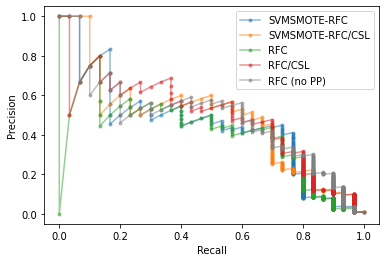

In [5]:
# init dfs for results
out_curves = pd.DataFrame(
    columns=["model", "precision", "recall", "threshold"]
)

out_eval = pd.DataFrame(
    index=np.arange(5), 
    columns=["model", "precision", "recall", "accuracy", "balanced_accuracy", "f1", "mcc", "tn", "fp", "fn", "tp", "aucpr"]
)

i = 0

for name, model in zip(
    ["SVMSMOTE-RFC", "SVMSMOTE-RFC/CSL", "RFC", "RFC/CSL"],
    [m1, m2, m3, m4]
):

    Y_test_proba = model.predict_proba(X_test_prepped)[:, 1]    # estimated P(class == "active")
    Y_pred = model.predict(X_test_prepped)                      # predicted class labels

    # construct precision-recall curve
    prec, rec, t = precision_recall_curve(Y_test, Y_test_proba)
    plt.plot(rec, prec, marker='.', label=name, alpha=0.5)
    
    t = np.append(t, t[-1])
    
    curves = pd.DataFrame({
        "model": name,
        "precision": prec,
        "recall": rec,
        "threshold": t
    })
    
    out_curves = out_curves.append(curves)

    # compute eval metrics
    scores = [
        scorer(Y_test, Y_pred) for scorer in [            
            precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef
        ]
    ]
    # add tn, fp, fn, tp
    scores.extend(confusion_matrix(Y_test, Y_pred).ravel())
    # add AUCPR
    scores.append(auc(rec, prec))
    # add name
    scores.insert(0, name)
    
    # store in df
    for col, value in zip(out_eval.columns, scores):
        out_eval[col][i] = value
    
    i += 1
    
    # print evaluation scores
    print(f"{name}\n{'-' * 80}")
    print(f"Precision:     {precision_score(Y_test, Y_pred):.2%}")
    print(f"Recall:        {recall_score(Y_test, Y_pred):.2%}")
    print(f"AUCPR:         {auc(rec, prec):.2%}")
    print(f"F1:            {f1_score(Y_test, Y_pred):.2%}")
    print(f"MCC:           {matthews_corrcoef(Y_test, Y_pred):.2%}")
    print()

# add m5: reference (on unprocessed ds)
Y_test_proba = m5.predict_proba(X_test)[:, 1]    # estimated P(class == "active")
Y_pred = m5.predict(X_test)                      # predicted class labels

# construct precision-recall curve
prec, rec, t = precision_recall_curve(Y_test, Y_test_proba)
plt.plot(rec, prec, marker='.', label="RFC (no PP)", alpha=0.5, c="grey")

t = np.append(t, t[-1])

curves = pd.DataFrame({
    "model": "RFC (no PP)",
    "precision": prec,
    "recall": rec,
    "threshold": t
})

out_curves = out_curves.append(curves)

# compute eval metrics
scores = [
    scorer(Y_test, Y_pred) for scorer in [            
        precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef
    ]
]

# add tn, fp, fn, tp
scores.extend(confusion_matrix(Y_test, Y_pred).ravel())
# add AUCPR
scores.append(auc(rec, prec))
# add name
scores.insert(0, "RFC (no PP)")

# store in df
for col, value in zip(out_eval.columns, scores):
    out_eval[col][4] = value

# print evaluation scores
print(f"RFC without preprocessing\n{'-' * 80}")
print(f"Precision:     {precision_score(Y_test, Y_pred):.2%}")
print(f"Recall:        {recall_score(Y_test, Y_pred):.2%}")
print(f"AUCPR:         {auc(rec, prec):.2%}")
print(f"F1:            {f1_score(Y_test, Y_pred):.2%}")
print(f"MCC:           {matthews_corrcoef(Y_test, Y_pred):.2%}")
print()

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [6]:
out_eval.to_csv("RFC_eval.csv")
out_curves.to_csv("RFC_eval_PRcurves.csv")